In [52]:
from sklearn.datasets import load_digits

In [53]:
digits = load_digits()

In [54]:
# Check the keys
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [55]:
# Grab the first digit instance
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [56]:
import matplotlib.pyplot as plt

In [57]:
# Reshape it to be a 8x8 again - dataset is pre-flattened for analysis
first_digit = digits.data[0]
first_digit_image = first_digit.reshape(8,8)

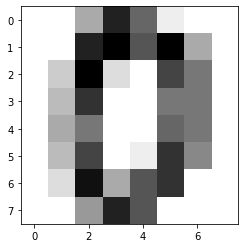

In [58]:
# Graph the first digit for an idea of the data
plt.imshow(first_digit_image, cmap="binary")

In [59]:
# Get number of observations so I can split into subsets for stacking
digits.data.shape

(1797, 64)

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
# Split out the training set
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3)

In [62]:
# Split the test into test and validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [63]:
# Check the allocation
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1257, 64)
(270, 64)
(270, 64)


## Build Individual Models

In [73]:
# Import library for checking scores
from sklearn.model_selection import cross_val_score

### SVM

In [80]:
from sklearn.linear_model import SGDClassifier 

In [81]:
# Build the model
svm_clf = SGDClassifier()

In [82]:
# Train the model
svm_clf.fit(X_train, y_train)

SGDClassifier()

In [83]:
# make prediction about training
y_pred = svm_clf.predict(X_train)

In [84]:
# Look at a 3 fold accuracy test 
cross_val_score(svm_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.94988067, 0.93556086, 0.93317422])

### Decision Trees

In [75]:
from sklearn.tree import DecisionTreeClassifier

In [85]:
# Build the model 
dt_clf = DecisionTreeClassifier(max_depth=10)

In [86]:
# Train the model
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [87]:
# Make predictions
y_pred = dt_clf.predict(X_train)

In [88]:
# Check the 3 fold accuracy
cross_val_score(dt_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.7875895 , 0.80906921, 0.85680191])

### Random Forest Ensemble

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
# Build the model
rdf_clf = RandomForestClassifier(n_estimators=200)

In [92]:
# Train the model
rdf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [93]:
# Make Predictions
y_pred = rdf_clf.predict(X_train)

In [94]:
# Check accuracy
cross_val_score(rdf_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.96181384, 0.98568019, 0.96658711])

## Individual Classifiers on Validation Set

We are now going to create an entirely new training set by running the individual models on the unseen validation set

In [104]:
# Grab numpy so we can concatenate
import numpy as np

In [112]:
# Run individual models 
y_pred_svm = svm_clf.predict(X_val)
y_pred_dt = dt_clf.predict(X_val)
y_pred_rdf = rdf_clf.predict(X_val)

In [113]:
# Create a unified training set
X_new = np.c_[y_pred_svm,y_pred_dt, y_pred_rdf]

# You can see where some are all predicting the same, and some different
X_new[:8]

array([[5, 5, 5],
       [4, 4, 4],
       [6, 6, 6],
       [5, 7, 5],
       [0, 6, 0],
       [7, 7, 7],
       [3, 3, 3],
       [3, 3, 2]])

In [114]:
# Build the blender model
rdf_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [115]:
# Feed it the previous predictions to train on
rdf_blender.fit(X_new, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [125]:
# Run an out of sample prediction on test
## Create an array of the estimators
estimators = [svm_clf, dt_clf, rdf_clf]

## Create an empty training array to iterate over
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.int8)

## Iterate over the empty array and fill with model predictions
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

# Then feed them to the blender
y_pred = rdf_blender.predict(X_test_predictions)

In [128]:
cross_val_score(rdf_blender, X_test_predictions, y_test, cv=5, scoring='accuracy')

array([0.96296296, 0.96296296, 0.98148148, 0.94444444, 0.96296296])

In [129]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9666666666666667